<a href="https://colab.research.google.com/github/Notmrcomedy/Fincomp/blob/main/Taller_3_Finanzas_computacionales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ana María Duarte

Juan José Morales

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
%pip install --quiet yfinance
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
!pip install --quiet pyDOE
from pyDOE import lhs

**Punto 1 - 
A.**

In [ ]:
activos = ["BA","DIS","KO","MSFT","V"]
precios = yf.download(activos,start="2017-12-01",end="2022-12-31",interval="1mo")["Adj Close"]
retornos = np.log(precios/precios.shift(1)).dropna()
indice = ["^DJI"]
p_ind = yf.download(indice,start="2017-12-01",end="2022-12-31",interval="1mo")["Adj Close"]
r_ind = np.log(p_ind/p_ind.shift(1)).dropna()

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
#retornos esperados
DF_retesp=pd.DataFrame(retornos.mean())
DF_retesp

,0
BA,-0.006482
DIS,-0.002953
KO,0.008096
MSFT,0.018183
V,0.010547


In [ ]:
#volatilidades
DF_volatilidad=pd.DataFrame(retornos.std())
DF_volatilidad

,0
BA,0.140849
DIS,0.092705
KO,0.057042
MSFT,0.061457
V,0.067957


In [ ]:
#betas
x = r_ind
y = retornos
t=len(x)
unos=pd.DataFrame(np.repeat(1,t))
x = pd.DataFrame(x)
y = pd.DataFrame(y)
unos.index = x.index
variables = pd.concat([unos,x],axis=1)

In [ ]:
X = variables.T@variables
Xy = variables.T@y
Sol = np.linalg.solve(X,Xy)
betas = Sol[1,:]
betas

array([1.77276166, 1.23803167, 0.69610321, 0.81505405, 0.99431812])

In [ ]:
DF_betas= pd.DataFrame(betas)
DF_betas.rename(index={0:"BA",1:"DIS",2:"KO",3:"MSFT",4:"V"},inplace=True)
DF_betas

,0
BA,1.772762
DIS,1.238032
KO,0.696103
MSFT,0.815054
V,0.994318


In [ ]:
rm = r_ind.mean()
capm=rm*betas
DF_capm=pd.DataFrame(capm)
DF_capm.rename(index={0:"BA",1:"DIS",2:"KO",3:"MSFT",4:"V"},inplace=True)
DF_capm

,0
BA,0.008668
DIS,0.006054
KO,0.003404
MSFT,0.003985
V,0.004862


In [ ]:
slope, intercept, r, p, std_error = stats.linregress(r_ind, retornos["DIS"])
rsquared_DIS= r**2
slope, intercept, r, p, std_error = stats.linregress(r_ind, retornos["KO"])
rsquared_KO= r**2
slope, intercept, r, p, std_error = stats.linregress(r_ind, retornos["V"])
rsquared_V= r**2
slope, intercept, r, p, std_error = stats.linregress(r_ind, retornos["MSFT"])
rsquared_MSFT= r**2
slope, intercept, r, p, std_error = stats.linregress(r_ind, retornos["BA"])
rsquared_BA= r**2

In [ ]:
DF_rsquared=pd.DataFrame([rsquared_BA,rsquared_DIS, rsquared_KO,  rsquared_MSFT, rsquared_V])
DF_rsquared.rename(index={0:"BA",1:"DIS",2:"KO",3:"MSFT",4:"V"},inplace=True)
DF_rsquared

,0
BA,0.455279
DIS,0.512555
KO,0.427994
MSFT,0.505486
V,0.615269


In [ ]:
DF_sum=pd.concat([DF_retesp,DF_volatilidad,DF_betas,DF_capm,DF_rsquared],axis=1)
DF_sum.columns = ["Retornos esperados","Volatilidades","Betas","CAPM","R squared"]
DF_sum

,Retornos esperados,Volatilidades,Betas,CAPM,R squared
BA,-0.006482,0.140849,1.772762,0.008668,0.455279
DIS,-0.002953,0.092705,1.238032,0.006054,0.512555
KO,0.008096,0.057042,0.696103,0.003404,0.427994
MSFT,0.018183,0.061457,0.815054,0.003985,0.505486
V,0.010547,0.067957,0.994318,0.004862,0.615269


A partir de esta tabla podemos observar que el porcentaje máximo de la variabilidad de los retornos de un activo, explicada por la variabilidad del mercado, es VISA, cuya variabilidad está explicada un 61,62% por el mercado, mientras que para las otras 4  es cerca del 50% o menos. Adicionalmente, llama la atención que las 2 acciones que tienen la mayor volatilidad, tienen los retornos esperados más bajos, cuando se esperaría que por su mayor riesgo ofrecieran la mayor rentabilidad, supuesto que sí se cumple cuando observamos el modelo CAPM en el cual a medida que aumenta la medida de riesgo (Beta) , aumentan los retonos esperados.

**Punto 1 - B.**

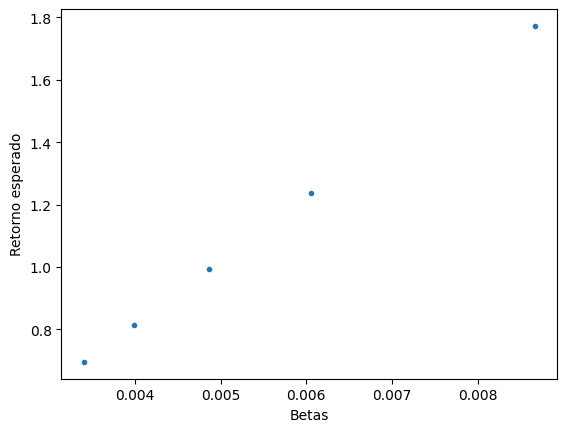

In [ ]:
plt.plot(capm,betas,".")
plt.ylabel("Retorno esperado")
plt.xlabel("Betas");

En este gráfico se puede comprobar lo mencionado anteriormente, los puntos representan cada una de las acciones en el plano riesgo (Beta) retorno (calculados por CAPM), las cuales a medida que aumentan su riesgo, incrementan su retorno esperado.

##Punto 2

In [ ]:

activos = ["DIS","KO","V","MSFT","BA"]
precios = yf.download(activos,start="2017-12-01",end="2022-12-31",interval="1mo")["Adj Close"]
retornos = np.log(precios/precios.shift(1)).dropna()
cov = retornos.cov()
mu=retornos.mean()
n = len(activos)
x=cp.Variable(n)
objetivo=cp.Minimize(cp.quad_form(x,cov))
restricciones=[cp.sum(x)==1,x>=0] 
prob=cp.Problem(objetivo,restricciones)
prob.solve()
wpt=x.value/sum(x.value)
wpt

[*********************100%***********************]  5 of 5 completed


array([1.78925971e-20, 1.22137031e-20, 5.48757389e-01, 4.37178536e-01,
       1.40640747e-02])

<BarContainer object of 5 artists>

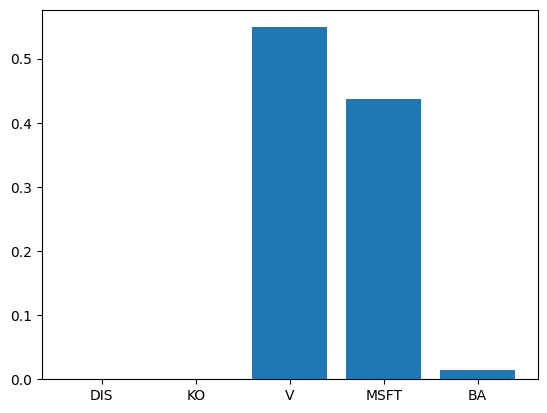

In [ ]:
plt.bar(activos,wpt)

In [ ]:
returns = retornos@wpt
rpt = returns.mean()
sigmapt = returns.std()
print(rpt, sigmapt)

0.012540329022261154 0.04839817505632769


In [ ]:
alpha = 0.05
VaRpt = rpt - stats.norm.ppf(1-alpha)*sigmapt 
VaRpt

-0.06706758475697172

In [ ]:
alpha = 0.01
VaRpt = rpt - stats.norm.ppf(1-alpha)*sigmapt 

-10.01

In [ ]:
var_historico = np.percentile(returns,1) #VaR histórico al 1%
var_historico

-0.10922065150822595

In [ ]:
rptm = wpt.T @ mu
sigmaptm = np.sqrt(wpt.T @ cov @ wpt)
rands_u = lhs(5,10000)
sim = stats.norm(rptm,sigmaptm).ppf(rands_u)
var_sim = np.percentile(sim,1)
print(round(var_sim*100,2),round(VaRpt*100,2),"Como se puede observar no hay diferencias significativas, los valores son prácticamente iguales.")

-10.0 -10.01 Como se puede observar no hay diferencias significativas, los valores son prácticamente iguales.


Encontramos por medio del cálculo del VaR parámetrico que con una frecuencia de la pérdida del 1% que el peor retorno del portafolio tangente sería del -10,01%, valor que comprobamos a partir de una simulación de 10.000 portafolios

##Punto 3

In [ ]:
activos = ["HSY"]
precios = yf.download(activos,start="2017-12-01",end="2022-12-31",interval="1mo")["Adj Close"]
retornos = np.log(precios/precios.shift(1)).dropna()
mu = retornos.mean()
sigma = retornos.std()

[*********************100%***********************]  1 of 1 completed


Date
2017-12-01    101.292831
2018-01-01     98.455116
2018-02-01     87.684219
2018-03-01     88.904640
2018-04-01     82.597961
                 ...    
2022-08-01    221.650528
2022-09-01    218.489075
2022-10-01    236.624649
2022-11-01    233.057007
2022-12-01    230.559753
Name: Adj Close, Length: 61, dtype: float64

In [ ]:
def PathsGBM(S0,mu,sigma,T,NS,M):    
    Z = np.random.normal(0.0,1.0,[NS,M])
    S = np.zeros([NS, M+1])
    S[:,0] = S0
    dt = T / M
    for t in range(0,M):
        S[:,t+1] = S[:,t] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) *Z[:,t])
    return S

In [ ]:
T= 1
mu = mu*12
sigma = sigma*np.sqrt(12)
S0 = precios[60]
NS = 10000
M = 12 
St = PathsGBM(S0,mu,sigma,T,NS,M)

Text(0.5, 0, 'Tiempo')

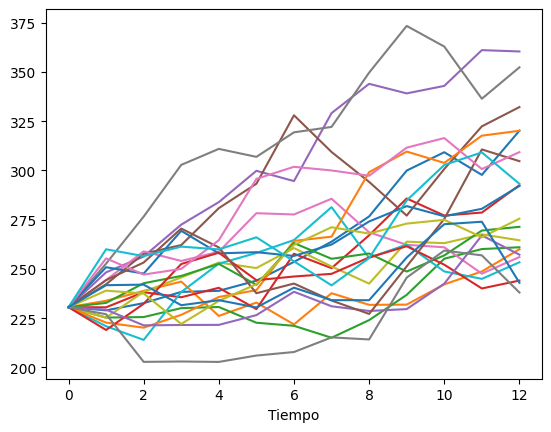

In [ ]:
plt.plot(np.transpose(St[0:21,:])) 
plt.xlabel("Tiempo")

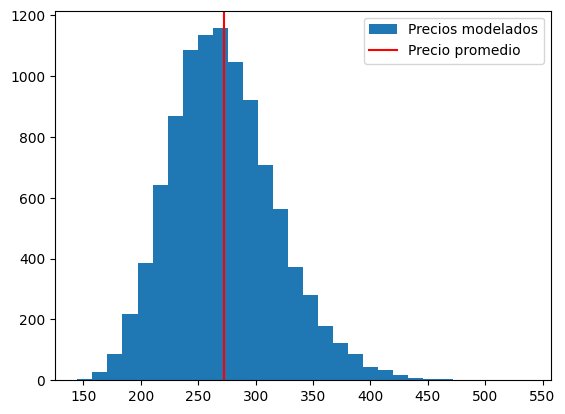

In [ ]:
plt.hist(St[:,-1], bins=30, label='Precios modelados')
plt.axvline(St[:,-1].mean(), color='r', label='Precio promedio')
plt.legend();

Se puede observar como si bien los valores tienen cierta uniformidad alrededor de la media, la distribución tiene una cola derecha  pesada, por lo que no termina de ser una distribución normal perfecta.

In [ ]:
precio_promedio_proyectado = St[:,-1].mean()
convergencia = S0*np.exp(mu*T)
precio_promedio_proyectado,convergencia

(272.5068504351498, 271.78433653317177)

In [ ]:
precios_proyectados = St[:,-1]
len(precios_proyectados[precios_proyectados<S0])/NS

0.1835

In [ ]:
print(precio_promedio_proyectado,S0)

272.5068504351498 230.55975341796875


A partir del proceso estocástico del movimiento Browniano geométrico, se pudo hacer una modelación del precio de la acción de Hersheys, y se concluyó a partir de una simulación de 10000 posibles precios futuros que la probabilidad que el precio de la acción sea menor al actual es de solo 18.35%, además estimamos que el precio de la acción en un año sería de 272.5 dólares, superior a los 230.56 que valía en diciembre de 2022, por lo que podría ser un activo interesante para invertir.

##Punto 4

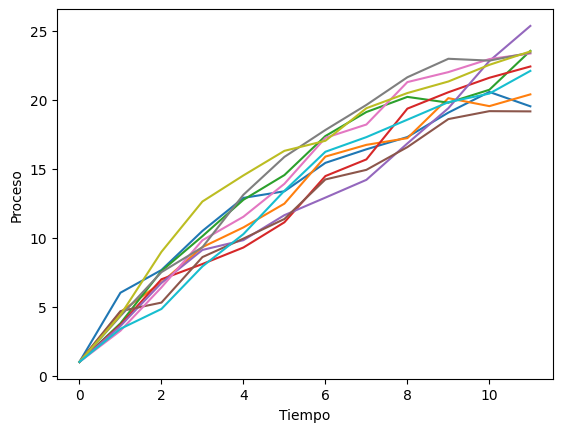

In [ ]:
def ou(x0, mu, sigma, k, t, m, ns):

    steps = t*m
    dt = t/steps
    y = np.zeros((ns, steps))
    for i in range(ns):
        x = np.zeros(steps)
        x[0] = x0
        for j in range(1, steps):
            x[j] = x[j-1] + k*(mu*m-x[j-1])*dt + sigma*np.sqrt(m)*np.random.normal()
        y[i] = x
    return y

x0 = 1               # Último valor de la serie
mu = 3               # Media de la serie
sigma = 0.3          # Desviación estándar de la serie
k = 1                # Parámetro de reversión
t = 5                # Tiempo a proyectar en años
m = 12               # Unidad de tiempo en la que quiero la simulación          
ns = 10000           # Número de simulaciones

y = ou(x0, mu, sigma, k, T, m, ns)

plt.plot(np.transpose(y[:10]))
plt.xlabel("Tiempo")
plt.ylabel("Proceso")
plt.show()

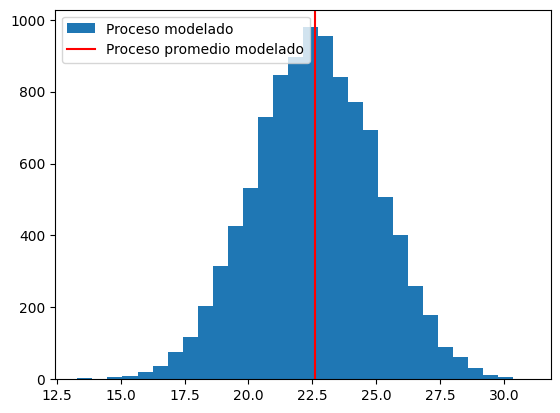

In [ ]:

plt.hist(y[:,-1], bins=30, label='Proceso modelado')
plt.axvline(y[:,-1].mean(), color='r', label='Proceso promedio modelado')
plt.legend();


Se puede observar que los datos se distribuyen de forma prácticamente simétrica respeto a la media, la distribución no cuenta con colas muy pesadas, por lo que se podría decir que es una distribución muy similar a la normal.

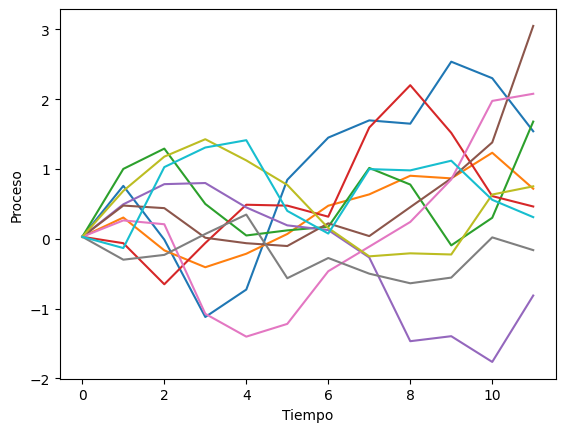

In [ ]:
x0 = 0.03               
mu = 0.05               
sigma = 0.15        
k = 1                
t = 1                
m = 12                        
ns = 100         

y = ou(x0, mu, sigma, k, T, m, ns)

plt.plot(np.transpose(y[:10]))
plt.xlabel("Tiempo")
plt.ylabel("Proceso")
plt.show()

##Punto 5


In [ ]:
activos = ["GC=F"]
precios = yf.download(activos,start="2005-01-01",end="2022-12-31",interval="1mo")["Adj Close"]
retornos = np.log(precios/precios.shift(1)).dropna()
mu = retornos.mean()
sigma = retornos.std()

[*********************100%***********************]  1 of 1 completed


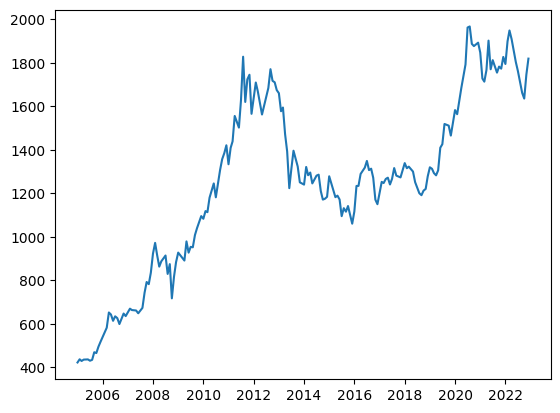

In [ ]:
plt.plot(precios)

In [ ]:
pruebadf1 = adfuller(precios) 
print("ADF test: %f" % pruebadf1[0])
print("P-value: %f" % pruebadf1[1])
print("Citical values:")
for key, value in pruebadf1[4].items():
  print("\t%s: %f" %(key,value))
  #La serie de precios del activo es no estacionaria a cualquier nivel de significancia

ADF test: -1.606097
P-value: 0.480530
Citical values:
	1%: -3.466398
	5%: -2.877380
	10%: -2.575214


In [ ]:
T=1 
mu = mu*12
sigma = sigma*np.sqrt(12)
S0 = precios[184]
NS = 100
M = 12 
St = PathsGBM(S0,mu,sigma,T,NS,M)

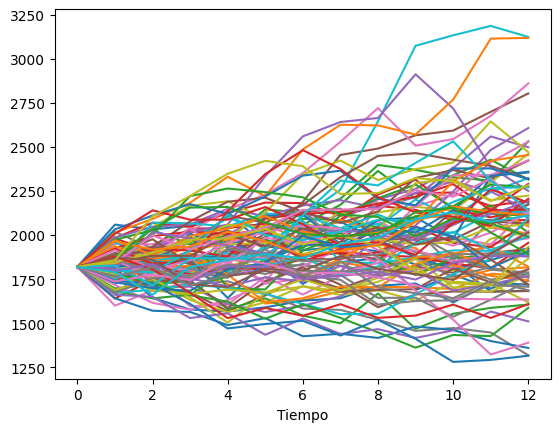

In [ ]:
plt.plot(np.transpose(St)) 
plt.xlabel("Tiempo");

In [ ]:
print(St[:,-1].mean(),precios[184])

2042.4003390134471 1819.699951171875


A partir de las simulación encontramos que el precio en un año podría aumentar de 1819.70 a 2042.4 por lo que mantener una posición larga en el futuro del oro sería la mejor opción, ya que al comprar al precio actual y vender en el futuro obtendríamos un margen considerable

In [ ]:
activos = ["KC=F"]
precios = yf.download(activos,start="2005-01-01",end="2022-12-31",interval="1mo")["Adj Close"]
retornos = np.log(precios/precios.shift(1)).dropna()
mu = retornos.mean()
sigma = retornos.std()

[*********************100%***********************]  1 of 1 completed


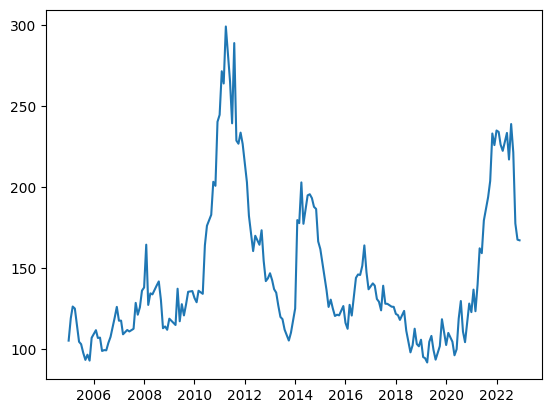

In [ ]:
plt.plot(precios)

In [ ]:
pruebadf1 = adfuller(precios) 
print("ADF test: %f" % pruebadf1[0])
print("P-value: %f" % pruebadf1[1])
print("Citical values:")
for key, value in pruebadf1[4].items():
  print("\t%s: %f" %(key,value))
#La serie de precios del activo es no estacionaria a un nivel de significancia del 1 %

ADF test: -3.329256
P-value: 0.013620
Citical values:
	1%: -3.467420
	5%: -2.877826
	10%: -2.575452


In [ ]:
T=1 
mu = mu*12
sigma = sigma*np.sqrt(12)
S0 = precios[184]
NS = 100 
M = 12 
St = PathsGBM(S0,mu,sigma,T,NS,M)

Text(0.5, 0, 'Tiempo')

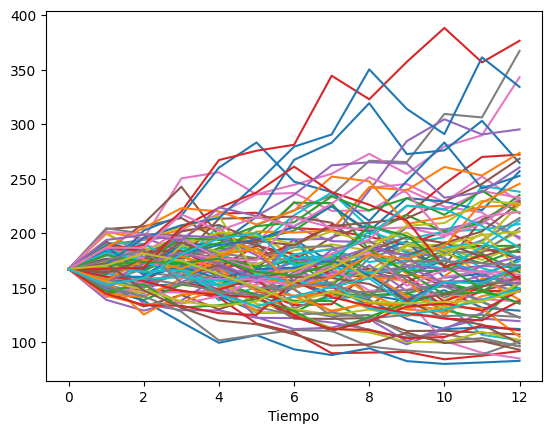

In [ ]:
plt.plot(np.transpose(St)) 
plt.xlabel("Tiempo")

In [ ]:
print(St[:,-1].mean(),precios[184])

179.85485467107048 167.3000030517578


De forma similar a los futuros del oro, los del café podrían llegar a subir según las simulaciones realizadas, aunque el margen obtenido sería menor, ya que su precio solo aumentaría de 167.3 a 179.85

In [ ]:
activos = ["EURUSD=X"]
precios = yf.download(activos,start="2005-01-01",end="2022-12-31",interval="1mo")["Adj Close"]
retornos = np.log(precios/precios.shift(1)).dropna()
mu = retornos.mean()
sigma = retornos.std()

[*********************100%***********************]  1 of 1 completed


In [ ]:
pruebadf1 = adfuller(precios) 
print("ADF test: %f" % pruebadf1[0])
print("P-value: %f" % pruebadf1[1])
print("Citical values:")
for key, value in pruebadf1[4].items():
  print("\t%s: %f" %(key,value))
#La serie de precios del activo es no estacionaria a cualquier nivel de significancia

ADF test: -1.748285
P-value: 0.406422
Citical values:
	1%: -3.461136
	5%: -2.875079
	10%: -2.573986


In [ ]:
T=1 
mu = mu*12
sigma = sigma*np.sqrt(12)
S0 = precios[215]
NS = 100 
M = 12 
St = PathsGBM(S0,mu,sigma,T,NS,M)

Text(0.5, 0, 'Tiempo')

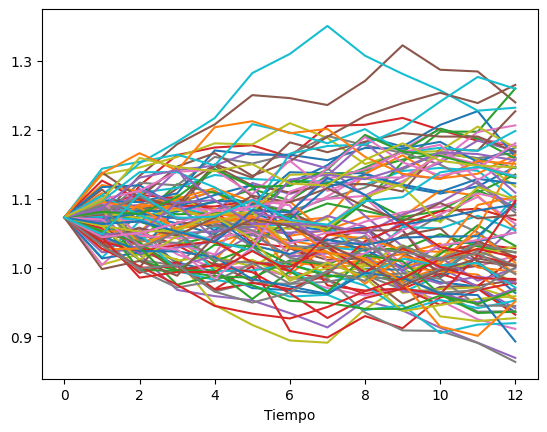

In [ ]:
plt.plot(np.transpose(St)) 
plt.xlabel("Tiempo")

In [ ]:
print(St[:,-1].mean(),precios[215])

1.0595363910743998 1.0728462934494019


Por su lado, se encontró a partir de la simulación que la tasa de cambio Euro/Dólar se va a reducir, lo que implica ya sea una depreciación del Euro o una apreciación del dólar, para ambos casos sería conveniente tener una posición corta en el euro y larga en dólares a la espera de la subida en su precio
